<a href="https://colab.research.google.com/github/shawdaena/Digial_Image_Processing/blob/main/hw19(DIP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=========== Bit Compression Summary (vs 24-bit) ===========
Original 24-bit color : 144384000 bits | Change: 0.00%
-----------------------------------------------------------
8-bit palette        : 48128000 bits | Change: 66.67%
8-bit 3-3-2 RGB      : 48128000 bits | Change: 66.67%
8-bit grayscale     : 48128000 bits | Change: 66.67%
5-bit grayscale     : 30080000 bits | Change: 79.17%
4-bit grayscale     : 24064000 bits | Change: 83.33%
2-bit grayscale     : 12032000 bits | Change: 91.67%
1-bit grayscale     : 6016000 bits | Change: 95.83%

=========== Quality Metrics (vs original grayscale) ===========
Method           |    MSE      |  PSNR (dB) |   SSIM
---------------  | ----------  | ---------- | ------
8-bit palette    |      12.50 |      37.16 | 0.9313
8-bit 3-3-2      |      48.56 |      31.27 | 0.7789
8-bit gray       |       0.00 |        inf | 1.0000
5-bit gray       |       5.44 |      40.77 | 0.9420
4-bit gray       |      21.20 |      34.87 | 0.8520
2-bit gray       |   

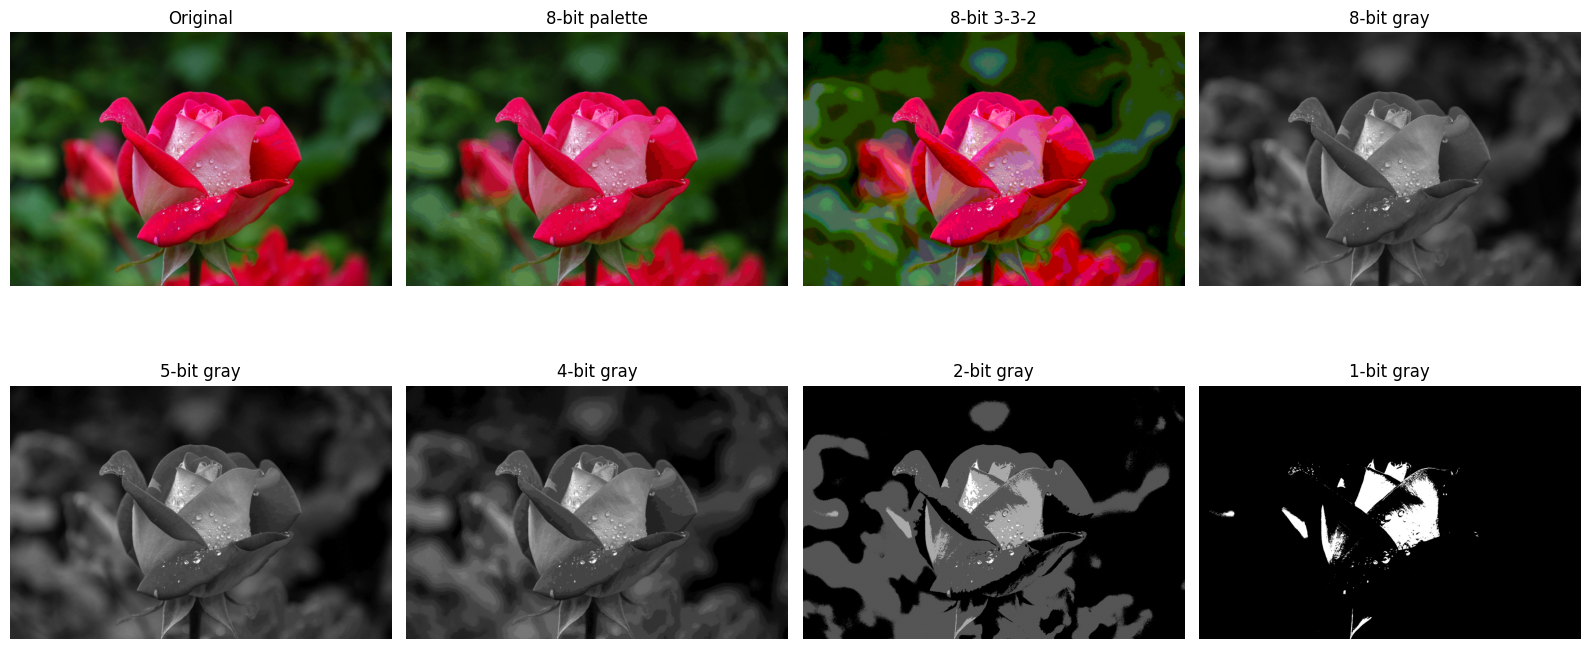

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

IMG_PATH = "/content/flower.png"


def quantize_gray(gray: np.ndarray, bits: int) -> np.ndarray:
    levels = 2 ** bits
    q = np.floor(gray.astype(np.float32) * levels / 256.0).astype(np.uint8)
    q = np.clip(q, 0, levels - 1)
    step = 256.0 / levels
    rec = q.astype(np.float32) * step + step / 2.0
    return np.clip(rec, 0, 255).astype(np.uint8)


def palette_8bit(img_bgr: np.ndarray, K: int = 256) -> np.ndarray:
    Z = img_bgr.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(
        Z, K, None, criteria, 3, cv2.KMEANS_RANDOM_CENTERS
    )
    centers = centers.astype(np.uint8)
    quant = centers[labels.flatten()]
    return quant.reshape(img_bgr.shape)


def quantize_3_3_2(img_bgr: np.ndarray) -> np.ndarray:
    b, g, r = cv2.split(img_bgr)

    r3 = np.round(r.astype(np.float32) * 7.0 / 255.0).astype(np.uint8)
    g3 = np.round(g.astype(np.float32) * 7.0 / 255.0).astype(np.uint8)
    b2 = np.round(b.astype(np.float32) * 3.0 / 255.0).astype(np.uint8)

    r_rec = np.round(r3.astype(np.float32) * 255.0 / 7.0).astype(np.uint8)
    g_rec = np.round(g3.astype(np.float32) * 255.0 / 7.0).astype(np.uint8)
    b_rec = np.round(b2.astype(np.float32) * 255.0 / 3.0).astype(np.uint8)

    return cv2.merge([b_rec, g_rec, r_rec])


def pct_change(orig_bits: int, new_bits: int) -> float:
    return 100.0 * (1.0 - new_bits / max(1, orig_bits))


# ---------- SSIM / MSE / PSNR ----------
def ssim_gray(x: np.ndarray, y: np.ndarray) -> float:
    x = x.astype(np.float32)
    y = y.astype(np.float32)

    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    kernel_size = (11, 11)
    sigma = 1.5

    mu_x = cv2.GaussianBlur(x, kernel_size, sigma)
    mu_y = cv2.GaussianBlur(y, kernel_size, sigma)

    mu_x2 = mu_x * mu_x
    mu_y2 = mu_y * mu_y
    mu_xy = mu_x * mu_y

    sigma_x2 = cv2.GaussianBlur(x * x, kernel_size, sigma) - mu_x2
    sigma_y2 = cv2.GaussianBlur(y * y, kernel_size, sigma) - mu_y2
    sigma_xy = cv2.GaussianBlur(x * y, kernel_size, sigma) - mu_xy

    num = (2 * mu_xy + C1) * (2 * sigma_xy + C2)
    den = (mu_x2 + mu_y2 + C1) * (sigma_x2 + sigma_y2 + C2)

    ssim_map = num / (den + 1e-12)
    return float(ssim_map.mean())


def mse_psnr_ssim(ref: np.ndarray, test: np.ndarray):
    ref = ref.astype(np.float32)
    test = test.astype(np.float32)
    mse = np.mean((ref - test) ** 2)
    if mse == 0:
        psnr = float("inf")
    else:
        psnr = 10.0 * math.log10((255.0 ** 2) / mse)
    s = ssim_gray(ref, test)
    return mse, psnr, s


def main():

    img_bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise ValueError("Could not read image: " + IMG_PATH)

    H, W, _ = img_bgr.shape
    orig_bits = H * W * 24

    # -------------- compression results stored in list -----------------
    results = []

    # color compressions
    img_palette = palette_8bit(img_bgr)
    img_332 = quantize_3_3_2(img_bgr)

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    gray_bits = [8, 5, 4, 2, 1]
    gray_imgs = [quantize_gray(gray, b) for b in gray_bits]

    # ---------------- Summary Print ----------------
    print("\n=========== Bit Compression Summary (vs 24-bit) ===========")
    print(f"Original 24-bit color : {orig_bits} bits | Change: 0.00%")
    print("-----------------------------------------------------------")

    # palette
    bits_palette = H * W * 8
    pct_palette = pct_change(orig_bits, bits_palette)
    print(f"8-bit palette        : {bits_palette} bits | Change: {pct_palette:.2f}%")

    # 3-3-2
    bits_332 = H * W * 8
    pct_332 = pct_change(orig_bits, bits_332)
    print(f"8-bit 3-3-2 RGB      : {bits_332} bits | Change: {pct_332:.2f}%")

    # grayscale
    for b in gray_bits:
        bits = H * W * b
        pct = pct_change(orig_bits, bits)
        print(f"{b}-bit grayscale     : {bits} bits | Change: {pct:.2f}%")

    print("===========================================================\n")

    # ---------------- Quality Metrics ----------------
    print("=========== Quality Metrics (vs original grayscale) ===========")
    print("Method           |    MSE      |  PSNR (dB) |   SSIM")
    print("---------------  | ----------  | ---------- | ------")

    pal_gray = cv2.cvtColor(img_palette, cv2.COLOR_BGR2GRAY)
    img_332_g = cv2.cvtColor(img_332, cv2.COLOR_BGR2GRAY)

    def print_metric(name, test_img):
        mse, psnr, ssim = mse_psnr_ssim(gray, test_img)
        print(f"{name:16} | {mse:10.2f} | {psnr:10.2f} | {ssim:6.4f}")

    print_metric("8-bit palette", pal_gray)
    print_metric("8-bit 3-3-2", img_332_g)
    print_metric("8-bit gray", gray_imgs[0])

    for b, gimg in zip(gray_bits[1:], gray_imgs[1:]):
        print_metric(f"{b}-bit gray", gimg)

    # -------------- Visualization (Loop) -------------
    imgs = [
        (cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB), "Original"),
        (cv2.cvtColor(img_palette, cv2.COLOR_BGR2RGB), "8-bit palette"),
        (cv2.cvtColor(img_332, cv2.COLOR_BGR2RGB), "8-bit 3-3-2"),
        (gray_imgs[0], "8-bit gray"),
        (gray_imgs[1], "5-bit gray"),
        (gray_imgs[2], "4-bit gray"),
        (gray_imgs[3], "2-bit gray"),
        (gray_imgs[4], "1-bit gray")
    ]

    plt.figure(figsize=(16, 8))
    for i, (im, title) in enumerate(imgs, 1):
        plt.subplot(2, 4, i)
        plt.title(title)
        if len(im.shape) == 2:
            plt.imshow(im, cmap="gray")
        else:
            plt.imshow(im)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
